# Set Up Scheduler Configuration

In [1]:
import sys
sys.path.append('/home/b/bechtol/repos/ts_config_ocs')

In [2]:
import Scheduler.feature_scheduler.maintel.fbs_config_fieldsurvey

In [3]:
nside, scheduler = Scheduler.feature_scheduler.maintel.fbs_config_fieldsurvey.get_scheduler()

In [4]:
scheduler.survey_lists

[[<FieldSurvey survey_name='Rubin_SV_095_-25', RA=1.6580627893946132, dec=-0.4363323129985824 at 0x7fa5a3397610>,
  <FieldSurvey survey_name='Rubin_SV_125_-15', RA=2.181661564992912, dec=-0.2617993877991494 at 0x7fa5a114ad50>,
  <FieldSurvey survey_name='DESI_SV3_R1', RA=3.134611336581816, dec=0.0 at 0x7fa5a112b3d0>,
  <FieldSurvey survey_name='Rubin_SV_225_-40', RA=3.9269908169872414, dec=-0.6981317007977318 at 0x7fa5a1362350>,
  <FieldSurvey survey_name='DEEP_A0', RA=3.7699111843077517, dec=-0.2181661564992912 at 0x7fa5a1151b90>,
  <FieldSurvey survey_name='Rubin_SV_250_2', RA=4.363323129985824, dec=0.03490658503988659 at 0x7fa5a10e2a90>,
  <FieldSurvey survey_name='Rubin_SV_300_-41', RA=5.235987755982989, dec=-0.7155849933176751 at 0x7fa5a10fad50>,
  <FieldSurvey survey_name='Rubin_SV_280_-48', RA=4.886921905584122, dec=-0.8377580409572782 at 0x7fa5a10ffb90>,
  <FieldSurvey survey_name='DEEP_B0', RA=5.410520681182422, dec=-0.33161255787892263 at 0x7fa5a1109650>,
  <FieldSurvey surve

In [5]:
scheduler.survey_lists[0][0].basis_functions

In [6]:
scheduler.survey_lists[0][0].detailers

# Set Up Model Observatory

In [7]:
import os
import warnings
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import healpy as hp
from astropy.time import Time

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site
from rubin_scheduler.data import get_data_dir

from rubin_scheduler.scheduler.model_observatory import ModelObservatory, KinemModel
from rubin_scheduler.site_models import ConstantSeeingData, ConstantWindData

from rubin_scheduler.utils import ra_dec2_hpid
from rubin_scheduler.scheduler.utils import empty_observation

from rubin_scheduler.scheduler import basis_functions
from rubin_scheduler.scheduler import features
from rubin_scheduler.scheduler.detailers import CameraSmallRotPerObservationListDetailer
from rubin_scheduler.scheduler.surveys import FieldSurvey
from rubin_scheduler.scheduler.schedulers import CoreScheduler, ComCamFilterSched
from rubin_scheduler.utils import Site, _approx_altaz2pa, pseudo_parallactic_angle, rotation_converter

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.utils import SchemaConverter

In [8]:
at_usdf = True
if at_usdf:
    #os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/group/rubin/shared/rubin_sim_data"
    os.environ["RUBIN_SIM_DATA_DIR"] = "/home/b/bechtol/rubin-user/rubin_sim_data"
print("Using rubin_sim_data from ", get_data_dir())

Using rubin_sim_data from  /home/b/bechtol/rubin-user/rubin_sim_data


In [9]:
# Setting the start of the *survey* (and keeping this the same) is important for the Model Observatory and Scheduler,
# because this sets an overall dither pattern per night, but also helps track things that may 
# otherwise change per night ... for SV surveys, might not be totally necessary, but is good practice
# (you can change the *day* / mjd that you are simulating, of course, but mjd_start should remain the same)

dayobs = '2024-09-09'
survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')

In [10]:
# Don't have to do this, but can grab almanac information

almanac = Almanac(mjd_start = survey_start.mjd)

def show_almanac_info(dayobs):
    night_info = almanac.get_sunset_info(evening_date=dayobs, longitude=Site('LSST').longitude_rad)
    
    dd = []
    for val, col in zip(night_info, night_info.dtype.names):
        if col == 'night':
            continue
        else:
            print(col, val, Time(val, format='mjd', scale='utc').iso)
    
    # And can check on the lunar phase -- this goes from 0 (new) to 100 (full)
    moon_phase = almanac.get_sun_moon_positions(night_info['moonrise'])['moon_phase']
    print(f'moonphase(%) {moon_phase.round(2)}')

show_almanac_info(dayobs)

sunset 60562.936555093154 2024-09-09 22:28:38.360
sun_n12_setting 60562.975207073614 2024-09-09 23:24:17.891
sun_n18_setting 60562.99454106344 2024-09-09 23:52:08.348
sun_n18_rising 60563.39397472935 2024-09-10 09:27:19.417
sun_n12_rising 60563.4132887749 2024-09-10 09:55:08.150
sunrise 60563.45188789442 2024-09-10 10:50:43.114
moonrise 60563.62073250674 2024-09-10 14:53:51.289
moonset 60563.19181374041 2024-09-10 04:36:12.707
moonphase(%) 46.25


In [11]:
def tma_movement(percent=70):
    # See https://confluence.lsstcorp.org/display/LSSTCOM/TMA+Motion+Settings
    # Expected performance at end of comcam on-sky is probably 10%
    if percent > 125:
        percent = 125
        print("Cannot exceed 125 percent, by requirements.")
    tma = {}
    scale = percent / 100.0
    tma['azimuth_maxspeed'] = np.min([10.0 * scale, 7.0])
    tma['azimuth_accel'] = 10.0 * scale
    tma['azimuth_jerk'] = np.max([1.0, 40.0 * scale])
    tma['altitude_maxspeed'] = 5.0 * scale
    tma['altitude_accel'] = 5.0 * scale
    tma['altitude_jerk'] = np.max([1.0, 20.0 * scale])
    tma['settle_time'] = 3.0
    return tma

In [12]:
def rotator_movement(percent=100):
    # Kevin and Brian say these can run 100% and are independent of TMA movement
    if percent > 125:
        percent = 125
        print("Cannot exceed 125 percent, by requirements.")
    rot = {}
    rot['maxspeed'] = 3.5 * percent/100
    rot['accel'] = 1.0 * percent/100
    rot['jerk'] = 4.0 * percent/100
    return rot

In [13]:
def get_model_observatory(dayobs='2024-09-09'):
    # Set up a fresh model observatory
    survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')
    mjd_now = survey_start.mjd

    kinematic_model = KinemModel(mjd0=mjd_now)
    kinematic_model.setup_camera(readtime=2.4, **rotator_movement(100.))
    kinematic_model.setup_telescope(**tma_movement(10.0))
    
    # Some weather telemetry that might be useful
    seeing_data = ConstantSeeingData(fwhm_500=2.0)
    wind_data = ConstantWindData(wind_direction=340, wind_speed=5.0)
    
    # Set up the model observatory
    observatory = ModelObservatory(mjd=mjd_now, 
                                   mjd_start=survey_start.mjd,
                                   kinem_model=kinematic_model, # Modified kinematics
                                   cloud_data='ideal',          # No clouds
                                   seeing_data=seeing_data,     # Modified seeing
                                   wind_data=wind_data,         # Add some wind
                                   downtimes='ideal',           # No downtime
                                   lax_dome=True,               # dome crawl?
                                   init_load_length=1,          # size of skybrightness files to load first
                                  )
    return observatory

In [14]:
def update_model_observatory_sunset(observatory, filter_scheduler):
    # Make sure correct filters are mounted
    conditions = observatory.return_conditions()
    filters_needed = filter_scheduler(conditions)
    observatory.observatory.mount_filters(filters_needed)
    conditions = observatory.return_conditions()
    print("Current filter set", conditions.mounted_filters)
    
    # Move ahead to twilight
    observatory.mjd = conditions.sun_n18_setting
    print("Current observatory time", observatory.mjd)
    return observatory

# Run Simulation

In [15]:
verbose = False

dayobs = '2024-09-09'
survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')
mjd_now = survey_start.mjd

# Set up again to be sure all is 'clean'
#scheduler, filter_scheduler = get_comcam_schedulers()
filter_scheduler = ComCamFilterSched()
observatory = get_model_observatory(dayobs)
observatory = update_model_observatory_sunset(observatory, filter_scheduler)
conditions = observatory.return_conditions()

mjd = observatory.mjd
mjd_end = conditions.sun_n12_rising
survey_length = 1 #mjd_end - mjd

observatory, scheduler, observations = sim_runner(
    observatory,
    scheduler,
    filter_scheduler=filter_scheduler,
    mjd_start=mjd,
    survey_length=survey_length,
    n_visit_limit=None,
    step_none=10.0,
    verbose=True,
    record_rewards=False,
    start_result_size=int(2e4),
    append_result_size=int(2.5e4),
)

/home/b/bechtol/repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/home/b/bechtol/repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:298: RuntimeWarning: All-NaN axis encountered
  rewards[i] = np.nanmax(survey.calc_reward_function(self.conditions))


Current filter set ['g', 'r', 'i']
Current observatory time 60562.99454106344
progress = 98.10%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 907 observations
ran in 0 min = 0.0 hours


In [16]:
sc = SchemaConverter()
visits = sc.obs2opsim(observations)

In [19]:
visits.columns

Index(['observationId', 'fieldRA', 'fieldDec', 'observationStartMJD',
       'flush_by_mjd', 'visitExposureTime', 'filter', 'rotSkyPos',
       'rotSkyPos_desired', 'numExposures', 'airmass', 'seeingFwhm500',
       'seeingFwhmEff', 'seeingFwhmGeom', 'skyBrightness', 'night', 'slewTime',
       'visitTime', 'slewDistance', 'fiveSigmaDepth', 'altitude', 'azimuth',
       'paraAngle', 'psudoParaAngle', 'cloud', 'moonAlt', 'sunAlt', 'note',
       'scheduler_note', 'target_name', 'block_id', 'observationStartLST',
       'rotTelPos', 'rotTelPos_backup', 'moonAz', 'sunAz', 'sunRA', 'sunDec',
       'moonRA', 'moonDec', 'moonDistance', 'solarElong', 'moonPhase',
       'cummTelAz', 'scripted_id', 'observation_reason', 'science_program',
       'json_block'],
      dtype='object')

In [20]:
# Let's check in on sequences, because there are some issues
visits.groupby('target_name')['observationStartMJD'].count()

target_name
DEEP_B0              60
ECDFS                29
EDFS_A              240
EDFS_B              120
ELAIS_S1            240
Rubin_SV_300_-41    158
XMM_LSS              60
Name: observationStartMJD, dtype: int64

In [21]:
# the time from the start of one exposure to the start of the next exposure:
slew_to_next_visit = visits['slewTime'][1:]
expected_overheads = visits['visitTime'][:-1].values + slew_to_next_visit.values
# Compare to the actual time between visits
actual_overheads = np.diff(visits['observationStartMJD'])*24*60*60 
# We can look at the difference to identify gaps in visits (seconds)
diff = np.abs(expected_overheads - actual_overheads)
indx = np.where((diff > 1) & (diff < 6*60*60))[0]
breaks = []
for i in indx:
    b1 = visits.iloc[i]['observationStartMJD']
    b2 = visits.iloc[i+1]['observationStartMJD']
    breaks.append([b1, b2])
print(indx)
print(breaks)

[]
[]


Text(0, 0.5, 'Airmass')

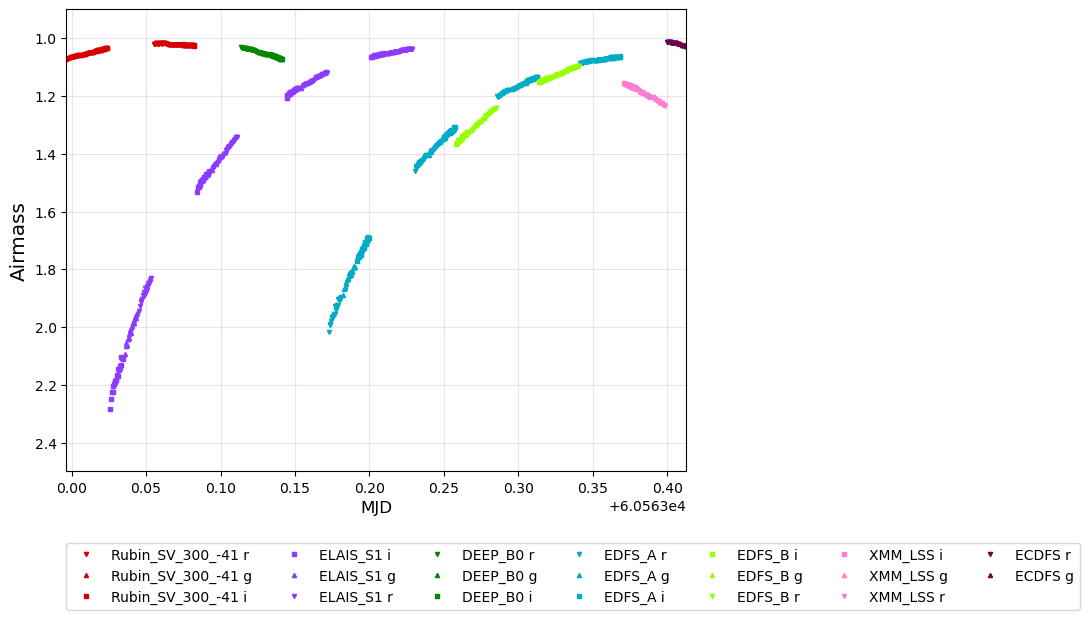

In [26]:
plt.figure(figsize=(8, 6))
filtershapes = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}
filtercolors = {'u': '#005BDB',
                'g': '#3DA952',
                'r': '#c61c00',
                'i': '#997500',
                'z': '#CE0D77',
                'y': '#5d0000'}
fieldcolors = {}
for i, t in enumerate(visits.target_name.unique()):
    fieldcolors[t] = cc.glasbey[i]

if len(breaks) > 0:
    for b in breaks:
        plt.fill_between(b, 2.5, 0.0, color='pink', alpha=0.3)

night = 1
nvisits = visits.query('night == @night')
for t in nvisits.target_name.unique():
    vv = nvisits.query('target_name == @t')
    for f in vv['filter'].unique():
        vvf = vv.query('filter == @f')
        label = f'{t} {f}'
        plt.plot(vvf.observationStartMJD, vvf.airmass, linestyle='', 
                 marker=filtershapes[f], markersize=3, color=fieldcolors[t], label=label)
plt.legend(loc=(0.00 , -0.3), ncols=len(nvisits.target_name.unique()))
plt.ylim(2.5, 0.9)
plt.xlim(nvisits.observationStartMJD.min(), nvisits.observationStartMJD.max())
plt.grid(alpha=0.3)
plt.xlabel("MJD", fontsize='large')
plt.ylabel("Airmass", fontsize='x-large')
#plt.title(f"Night {night}, {Time(nights.observationStartMJD.min(), format='mjd', scale='utc').isot.split("T")[0]}")

# Scratch

In [ ]:
import lsst.ts.fbs.utils
lsst.ts.fbs.utils

In [ ]:
#import lsst.ts.config.ocs

In [ ]:
import rubin_scheduler
rubin_scheduler

In [ ]:
from lsst.ts.fbs.utils.maintel import MakeFieldSurveyScheduler

In [ ]:
nside = 32

In [ ]:
make_scheduler = MakeFieldSurveyScheduler()

In [ ]:
make_scheduler.nside

In [ ]:
sequence="rgi"
nvis=[30, 30, 30]
survey_name="test"

In [ ]:
make_scheduler._load_candidate_fields()

In [ ]:
field_names = [
    "EDFS_A", 
    "EDFS_B",
]
make_scheduler.add_field_surveys(field_names, sequence=sequence, nvis=nvis, survey_name=survey_name)

In [ ]:
make_scheduler.surveys[1]

In [ ]:
make_scheduler.get_scheduler()

# Scheduler Config Testing

In [ ]:
import sys
sys.path.append('/home/b/bechtol/repos/ts_config_ocs')

In [ ]:
#import Scheduler.feature_scheduler.auxtel.fbs_config_image_photocal_survey

In [ ]:
#Scheduler.feature_scheduler.auxtel.fbs_config_image_photocal_survey.get_scheduler()

In [ ]:
import Scheduler.feature_scheduler.maintel.fbs_config_fieldsurvey

In [ ]:
nside, scheduler = Scheduler.feature_scheduler.maintel.fbs_config_fieldsurvey.get_scheduler()

In [ ]:
scheduler.survey_lists

In [ ]:
dir(scheduler.survey_lists[0][0])

In [ ]:
scheduler.survey_lists[0][0].basis_functions

In [ ]:
scheduler.survey_lists[0][0].detailers

# Run Simulation Simple

In [ ]:
import copy
import numpy as np

from astropy.time import Time

import matplotlib.pylab as plt

In [ ]:
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.site_models import SeeingData
from rubin_scheduler.scheduler import  sim_runner

In [ ]:
# There ought to be a way to set the environment variable for this kernel
import os
os.environ["RUBIN_SIM_DATA_DIR"] = "/home/b/bechtol/rubin-user/rubin_sim_data"
os.getenv("RUBIN_SIM_DATA_DIR")

In [ ]:
# Note that can only set this date after downloading the full set sky brightness data
mjd_start = Time('2024-09-01 00:00:00.000', format='iso').mjd
mjd_start

In [ ]:
# We need the start date of the survey, so let's load up our model observatory and get that from the conditions
mo = ModelObservatory(nside=nside, ideal_conditions=True, mjd_start=mjd_start)
mo.seeing_data = SeeingData(Time(mjd_start, format='mjd'))
conditions = mo.return_conditions()

In [ ]:
conditions.mounted_filters = ['gjgj', 'ghghi', 'kykykz']
conditions.mounted_filters

In [ ]:
mo.conditions.mounted_filters

In [ ]:
new_mo, new_scheduler, observations = sim_runner(copy.deepcopy(mo), copy.deepcopy(scheduler), survey_length=0.2, verbose=True)
del new_mo
del new_scheduler

In [ ]:
observations.dtype.names

In [ ]:
observations['filter']

In [ ]:
observations[0]

In [ ]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

plt.figure(dpi=200)
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], observations['airmass'][in_filt], 
                 'o', markersize=1, color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Airmass')